In [1]:
!sudo apt update && sudo apt install -y tesseract-ocr


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [65.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,533 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates

In [2]:
%pip install opencv-python numpy pytesseract easyocr paddleocr pillow matplotlib python-Levenshtein paddlepaddle jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 755.6 kB/s eta 0:00:00
   ━━━━━

In [3]:
import cv2
import numpy as np
import pytesseract
import easyocr
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import Levenshtein  # For accuracy metrics
from datetime import datetime, timedelta
import random
import os
import jiwer
import json
from tqdm import tqdm
import time
import pandas as pd
import seaborn as sns
import gc

In [4]:
class EmailScreenshotGenerator:
    def __init__(self, output_dir="synthetic_email_screenshots"):
        """Initialize the email screenshot generator.

        Args:
            output_dir: Directory to save generated images
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Create metadata directory for ground truth
        self.metadata_dir = os.path.join(output_dir, "metadata")
        os.makedirs(self.metadata_dir, exist_ok=True)

        # Load fonts
        try:
            self.header_font = ImageFont.truetype("arial.ttf", 24)
            self.title_font = ImageFont.truetype("arial.ttf", 20)
            self.body_font = ImageFont.truetype("arial.ttf", 16)
            self.button_font = ImageFont.truetype("arial.ttf", 14)
        except IOError:
            # Fallback to default font if arial not available
            self.header_font = ImageFont.load_default()
            self.title_font = ImageFont.load_default()
            self.body_font = ImageFont.load_default()
            self.button_font = ImageFont.load_default()

        # Email components
        self.email_providers = ["gmail", "outlook", "yahoo", "protonmail", "icloud", "zoho", "aol", "fastmail", "gmx"]
        self.safe_senders = [
          "notifications@amazon.com", "info@linkedin.com", "updates@twitter.com",
          "newsletter@nytimes.com", "billing@netflix.com", "team@slack.com",
          "support@github.com", "alerts@bankofamerica.com", "no-reply@apple.com",
          "contact@google.com", "updates@microsoft.com", "customer@paypal.com",
          "info@uber.com", "news@medium.com", "support@spotify.com"
        ]
        self.malicious_senders = [
          "amazon-support@secure-orders.net", "paypal-verify@accounts-update.com",
          "apple-id@secure-verification.org", "microsoft365@password-reset.net",
          "bank-of-america@secure-banking.info", "netflix@billing-update.co",
          "support@secure-dropbox.net", "google-security@verify-login.com",
          "admin@facebook-support.com", "billing@crypto-exchange.info",
          "apple-billing@apple-id-secure.net", "chase@secure-banking-alert.com",
          "amazon-service@account-locked.net", "helpdesk@microsoft-secure.net"
        ]
        self.safe_subjects = [
          "Your order has shipped", "Meeting reminder", "Invoice for your recent purchase",
          "Weekly newsletter", "Your subscription renewal", "Team update",
          "Security update from Google", "Your monthly account statement",
          "Exclusive discount just for you!", "Your delivery is on the way",
          "Thank you for your recent purchase!", "Invitation to our webinar",
          "New message from your network", "Your ticket has been updated",
          "Exciting new features available now!"
        ]
        self.malicious_subjects = [
          "URGENT: Account verification required", "Your payment failed",
          "Security alert - unusual activity", "Password reset required immediately",
          "Your account has been locked", "Claim your refund now",
          "CONFIRM IMMEDIATELY: Suspicious login detected", "Final warning: Account closure imminent",
          "Congratulations! You won a free iPhone", "Unpaid invoice - resolve now",
          "Dear customer, your credit card is at risk", "IMPORTANT: Verify your identity",
          "Immediate action required: Payment issue", "Your tax refund is ready to claim",
          "Confirm your details for uninterrupted service"
        ]

        # Add email themes
        self.themes = {
            "light": {
                "name": "Light Theme",
                "bg_color": (248, 249, 250),       # Light gray background
                "header_bg": (240, 242, 245),      # Slightly darker header
                "text_color": (40, 40, 40),        # Dark gray text
                "secondary_text": (100, 100, 100), # Medium gray text
                "separator": (200, 200, 200),      # Light gray separator
                "button_bg": (0, 120, 212),        # Blue button
                "button_border": (0, 80, 180),     # Darker blue border
                "button_text": (255, 255, 255)     # White button text
            },
            "dark": {
                "name": "Dark Theme",
                "bg_color": (30, 30, 30),          # Dark background
                "header_bg": (18, 18, 18),         # Darker header
                "text_color": (220, 220, 220),     # Light gray text
                "secondary_text": (180, 180, 180), # Medium light gray text
                "separator": (80, 80, 80),         # Medium dark separator
                "button_bg": (0, 120, 212),        # Blue button
                "button_border": (0, 80, 180),     # Darker blue border
                "button_text": (255, 255, 255)     # White button text
            },
            "sepia": {
                "name": "Sepia Theme",
                "bg_color": (249, 241, 228),       # Light sepia background
                "header_bg": (242, 232, 212),      # Slightly darker sepia
                "text_color": (70, 50, 30),        # Dark brown text
                "secondary_text": (120, 100, 80),  # Medium brown text
                "separator": (210, 190, 170),      # Light brown separator
                "button_bg": (180, 120, 70),       # Brown button
                "button_border": (150, 90, 50),    # Darker brown border
                "button_text": (255, 255, 255)     # White button text
            },
            "blue": {
                "name": "Blue Theme",
                "bg_color": (235, 245, 255),       # Light blue background
                "header_bg": (210, 230, 250),      # Slightly darker blue header
                "text_color": (20, 50, 80),        # Dark blue text
                "secondary_text": (80, 110, 140),  # Medium blue text
                "separator": (180, 200, 220),      # Light blue separator
                "button_bg": (40, 80, 180),        # Blue button
                "button_border": (20, 60, 160),    # Darker blue border
                "button_text": (255, 255, 255)     # White button text
            }
        }

    def generate_random_date(self):
        """Generate a random recent date string."""
        days_ago = random.randint(0, 14)
        date = datetime.now() - timedelta(days=days_ago)
        if days_ago == 0:
            return "Today"
        elif days_ago == 1:
            return "Yesterday"
        else:
            return date.strftime("%b %d")

    def add_noise(self, img, noise_type="gaussian", severity=0.1):
        """Add noise to the image to simulate real screenshots.

        Args:
            img: PIL Image
            noise_type: Type of noise to add ("gaussian", "salt_pepper", or "blur")
            severity: Noise severity (0.0 to 1.0)

        Returns:
            PIL Image with noise
        """
        # Convert PIL to cv2
        cv_img = np.array(img)

        if noise_type == "gaussian":
            # Add Gaussian noise
            mean = 0
            sigma = 25 * severity
            noise = np.random.normal(mean, sigma, cv_img.shape).astype(np.uint8)
            cv_img = cv2.add(cv_img, noise)

        elif noise_type == "salt_pepper":
            # Add salt and pepper noise
            prob = severity * 0.05
            black = np.random.random(cv_img.shape[:2])
            white = np.random.random(cv_img.shape[:2])
            cv_img[black < prob] = 0
            cv_img[white > (1 - prob)] = 255

        elif noise_type == "blur":
            # Add blur
            blur_factor = int(5 * severity) * 2 + 1  # Ensure odd number
            cv_img = cv2.GaussianBlur(cv_img, (blur_factor, blur_factor), 0)

        # Convert back to PIL
        return Image.fromarray(cv_img)

    def generate_email_screenshot(self, is_malicious, index, theme=None, add_noise=True, noise_severity=0.1):
        """Generate a synthetic email screenshot.

        Args:
            is_malicious: Whether to generate a malicious email
            index: Index number for the filename
            theme: Theme to use (if None, a random theme will be selected)
            add_noise: Whether to add noise to the image
            noise_severity: Level of noise to add (0.0 to 1.0)

        Returns:
            Tuple of (filepath, ground_truth_text, metadata)
        """
        # Select theme if not specified
        if theme is None:
            theme_key = random.choice(list(self.themes.keys()))
            theme = self.themes[theme_key]
        elif isinstance(theme, str):
            theme = self.themes.get(theme, self.themes["light"])

        # Create base image
        width, height = 800, 600
        img = Image.new('RGB', (width, height), color=theme["bg_color"])
        draw = ImageDraw.Draw(img)

        # Select email provider
        provider = random.choice(self.email_providers)

        # Draw header
        draw.rectangle([(0, 0), (width, 60)], fill=theme["header_bg"])
        draw.text((20, 15), f"{provider.capitalize()} Mail", font=self.header_font, fill=theme["text_color"])

        # Select sender and subject
        if is_malicious:
            sender = random.choice(self.malicious_senders)
            subject = random.choice(self.malicious_subjects)
            category = "Malicious"
        else:
            sender = random.choice(self.safe_senders)
            subject = random.choice(self.safe_subjects)
            category = "Safe"

        # Draw email details
        date_str = self.generate_random_date()
        y_pos = 80
        draw.text((20, y_pos), f"From: {sender}", font=self.title_font, fill=theme["text_color"])
        y_pos += 35
        draw.text((20, y_pos), f"Subject: {subject}", font=self.title_font, fill=theme["text_color"])
        y_pos += 35
        draw.text((20, y_pos), f"Date: {date_str}", font=self.title_font, fill=theme["secondary_text"])

        # Draw separator
        y_pos += 40
        draw.line([(20, y_pos), (width-20, y_pos)], fill=theme["separator"], width=1)
        y_pos += 20

        # Generate and draw email body
        if is_malicious:
            body_text = self.generate_malicious_body()
        else:
            body_text = self.generate_safe_body()

        # Wrap text to fit width
        wrapped_lines = []
        max_chars_per_line = 70
        for paragraph in body_text.split('\n\n'):
            words = paragraph.split()
            current_line = ""

            for word in words:
                if len(current_line + " " + word) <= max_chars_per_line:
                    current_line += " " + word if current_line else word
                else:
                    wrapped_lines.append(current_line)
                    current_line = word

            if current_line:
                wrapped_lines.append(current_line)
            wrapped_lines.append("")  # Add blank line between paragraphs

        # Draw body text
        for line in wrapped_lines:
            draw.text((20, y_pos), line, font=self.body_font, fill=theme["text_color"])
            y_pos += 25

        # Button text for malicious emails
        button_text = ""
        if is_malicious:
            y_pos += 15
            button_text = random.choice(["Verify Now", "Update Account", "Sign In", "Claim Refund"])
            button_width = 180
            button_height = 40
            button_x = 20
            button_y = y_pos

            # Draw button
            draw.rectangle([(button_x, button_y), (button_x + button_width, button_y + button_height)],
                          fill=theme["button_bg"], outline=theme["button_border"])

            # Calculate text position for centering
            text_width = draw.textlength(button_text, font=self.button_font)
            text_x = button_x + (button_width - text_width) / 2
            text_y = button_y + (button_height - 14) / 2  # Approximate height adjustment

            draw.text((text_x, text_y), button_text, font=self.button_font, fill=theme["button_text"])

        # Apply noise if requested
        if add_noise:
            noise_type = random.choice(["gaussian", "salt_pepper", "blur"])
            img = self.add_noise(img, noise_type, noise_severity)

        # Save image
        theme_name = theme.get("name", "Custom").replace(" ", "").lower()
        filename = f"{category.lower()}_{theme_name}_email_{index:03d}.png"
        filepath = os.path.join(self.output_dir, filename)
        img.save(filepath)

        # Compile text content for ground truth
        header_text = f"{provider.capitalize()} Mail"
        email_details = f"From: {sender}\nSubject: {subject}\nDate: {date_str}"

        # Full text content (what should be recognized by OCR)
        full_text = f"{header_text}\n{email_details}\n\n{body_text}"
        if button_text:
            full_text += f"\n\n{button_text}"

        # Save text content to a plain text file
        text_filename = f"{os.path.splitext(filename)[0]}.txt"
        text_filepath = os.path.join(self.metadata_dir, text_filename)
        with open(text_filepath, 'w') as f:
            f.write(full_text)

        return filepath, full_text

    def generate_safe_body(self):
        """Generate random safe email body text."""
        templates = [
          "Dear Customer,\n\nThank you for your recent purchase. Your order has been processed and will be shipped within the next 2 business days.\n\nYou can track your package using the order number provided in your confirmation email.\n\nBest regards,\nCustomer Service Team",

          "Hi there,\n\nJust a reminder that we have scheduled a team meeting tomorrow at 10:00 AM. Please prepare your weekly updates to share with the team.\n\nThe meeting link has been sent to your calendar.\n\nThanks,\nTeam Coordinator",

          "Hello,\n\nYour subscription will renew automatically on the 15th of next month. If you wish to make any changes to your plan, please log in to your account and update your preferences.\n\nThank you for being a valued customer.\n\nRegards,\nBilling Department",

          "Dear Member,\n\nWe're excited to share our weekly newsletter with you. This week's highlights include:\n\n- New product launches\n- Community spotlight\n- Upcoming events\n\nClick the link in your email to read the full newsletter.\n\nHave a great day!\nNewsletter Team",

          "Hello,\n\nThis is a confirmation that your appointment has been scheduled for next Tuesday at 2:30 PM. Please arrive 15 minutes early to complete any necessary paperwork.\n\nIf you need to reschedule, please contact our office at least 24 hours in advance.\n\nBest regards,\nScheduling Department",

          "Dear Valued Customer,\n\nWe appreciate your continued support. As a token of our gratitude, we're offering an exclusive 10% discount on your next purchase. Use the code THANKYOU10 at checkout.\n\nBest regards,\nCustomer Support Team",

          "Hello Team,\n\nOur weekly stand-up meeting has been moved to Wednesday at 11:00 AM instead of the usual Tuesday slot. Please update your schedules accordingly.\n\nThanks,\nManagement Team",

          "Hi there,\n\nWe're introducing new features to enhance your user experience. Check out the latest updates in your dashboard and let us know your feedback.\n\nEnjoy exploring the new features!\nSupport Team",

          "Dear Subscriber,\n\nYour monthly newsletter is here! This edition covers:\n\n- Tips & Tricks for Productivity\n- Upcoming Community Events\n- Special Member Discounts\n\nClick the link in your email to read more.\n\nBest,\nThe Newsletter Team",

          "Hello,\n\nWe noticed you haven't used your rewards points in a while! Redeem them before they expire next month and enjoy great discounts on your next purchase.\n\nCheck your balance now in your account dashboard.\n\nBest wishes,\nLoyalty Program Team"
        ]

        return random.choice(templates)

    def generate_malicious_body(self):
        """Generate random malicious email body text."""
        templates = [
            "URGENT NOTICE:\n\nWe have detected suspicious activity on your account. Your account access has been limited as a security measure.\n\nTo restore full access to your account, you must verify your identity immediately by clicking the button below.\n\nFailure to verify within 24 hours will result in permanent account suspension.\n\nSecurity Team",

            "Important Security Alert:\n\nYour password was recently changed. If you did not request this change, your account may have been compromised.\n\nPlease click the button below to secure your account immediately.\n\nThis link will expire in 30 minutes.\n\nAccount Security",

            "Payment Failed Notice:\n\nWe were unable to process your monthly payment due to a problem with your payment method.\n\nTo avoid service interruption, please update your billing information by clicking the button below.\n\nYour service will be suspended in 48 hours if payment is not received.\n\nBilling Department",

            "Tax Refund Notification:\n\nAfter the latest calculation of your fiscal activity, we have determined that you are eligible for a tax refund of $783.50.\n\nTo claim your refund, please verify your information by clicking the button below.\n\nRefunds not claimed within 7 days will be forfeit.\n\nTax Department",

            "Account Verification Required:\n\nDue to recent updates to our security system, all users must re-verify their account information.\n\nYour account will be restricted until verification is complete.\n\nPlease click the button below to verify your account now.\n\nSystem Administrator",

            "Final Warning: Immediate Action Required\n\nYour account has been flagged for suspicious activity. To prevent deactivation, verify your account by clicking the link below.\n\nFailure to act within 24 hours will result in account suspension.\n\nSecurity Team",

            "Invoice Overdue Notice\n\nYour most recent invoice remains unpaid. Please clear the balance immediately to avoid penalties.\n\nClick below to process the payment securely.\n\nFinance Department",

            "Congratulations! You have won a special prize!\n\nTo claim your reward, please verify your details by clicking the secure link below.\n\nHurry! This exclusive offer expires in 48 hours.\n\nPromotions Team",

            "Unusual Login Attempt Detected\n\nWe detected a login attempt from a new device. If this wasn't you, secure your account now by clicking the link below.\n\nFailure to verify will result in account restrictions.\n\nSecurity Services",

            "Pending Tax Refund – Action Required\n\nOur records show that you are eligible for a tax refund of $950.00. To claim it, confirm your details through the link below.\n\nRefunds must be claimed within 3 days.\n\nTax Authority"
        ]
        return random.choice(templates)

    def generate_themed_dataset(self, num_safe_per_theme=5, num_malicious_per_theme=5, noise_level=0.2):
        """Generate a dataset with equal distribution of all themes."""
        dataset = {
            "filepaths": [],
            "ground_truth": {}
        }

        for theme_key in self.themes.keys():
            print(f"Generating emails with {self.themes[theme_key]['name']}...")

            # Generate safe emails for this theme
            for i in range(num_safe_per_theme):
                filepath, text = self.generate_email_screenshot(  # Changed here - now just unpacking 2 values
                    is_malicious=False,
                    index=i+1,
                    theme=theme_key,
                    noise_severity=noise_level
                )
                dataset["filepaths"].append(filepath)
                dataset["ground_truth"][filepath] = text

            # Generate malicious emails for this theme
            for i in range(num_malicious_per_theme):
                filepath, text = self.generate_email_screenshot(  # Changed here - now just unpacking 2 values
                    is_malicious=True,
                    index=i+1,
                    theme=theme_key,
                    noise_severity=noise_level
                )
                dataset["filepaths"].append(filepath)
                dataset["ground_truth"][filepath] = text

        # Save full dataset information (modified to remove metadata which isn't being returned)
        dataset_path = os.path.join(self.output_dir, "dataset_info.json")
        with open(dataset_path, 'w') as f:
            # Create a serializable version
            serializable_dataset = {
                "filepaths": dataset["filepaths"],
                "ground_truth": {k: v for k, v in dataset["ground_truth"].items()}
                # Removed metadata line which isn't being collected
            }
            json.dump(serializable_dataset, f, indent=2)

        total = len(dataset["filepaths"])
        print(f"Generated {total} email screenshots in {self.output_dir}")
        print(f"Dataset information saved to {dataset_path}")

        return dataset

In [5]:
!rm -rf synthetic_email_screenshots/
!rm test.zip

rm: cannot remove 'test.zip': No such file or directory


In [6]:
generator = EmailScreenshotGenerator()

# Generate a mixed dataset with random themes
# filepaths = generator.generate_dataset(num_safe=5, num_malicious=5)

# Or generate a dataset with equal distribution of all themes
filepaths = generator.generate_themed_dataset(num_safe_per_theme=1, num_malicious_per_theme=1)

print("Generated files:")
for fp in filepaths:
    print(f"- {fp}")

Generating emails with Light Theme...
Generating emails with Dark Theme...
Generating emails with Sepia Theme...
Generating emails with Blue Theme...
Generated 8 email screenshots in synthetic_email_screenshots
Dataset information saved to synthetic_email_screenshots/dataset_info.json
Generated files:
- filepaths
- ground_truth


In [7]:
!zip -r test.zip synthetic_email_screenshots

  adding: synthetic_email_screenshots/ (stored 0%)
  adding: synthetic_email_screenshots/safe_bluetheme_email_001.png (deflated 0%)
  adding: synthetic_email_screenshots/metadata/ (stored 0%)
  adding: synthetic_email_screenshots/metadata/malicious_lighttheme_email_001.txt (deflated 26%)
  adding: synthetic_email_screenshots/metadata/safe_sepiatheme_email_001.txt (deflated 30%)
  adding: synthetic_email_screenshots/metadata/safe_lighttheme_email_001.txt (deflated 31%)
  adding: synthetic_email_screenshots/metadata/malicious_bluetheme_email_001.txt (deflated 26%)
  adding: synthetic_email_screenshots/metadata/safe_bluetheme_email_001.txt (deflated 30%)
  adding: synthetic_email_screenshots/metadata/malicious_sepiatheme_email_001.txt (deflated 36%)
  adding: synthetic_email_screenshots/metadata/malicious_darktheme_email_001.txt (deflated 35%)
  adding: synthetic_email_screenshots/metadata/safe_darktheme_email_001.txt (deflated 25%)
  adding: synthetic_email_screenshots/malicious_darkthem

In [8]:
def calculate_text_similarity(text1, text2):
    from difflib import SequenceMatcher
    return SequenceMatcher(None, text1, text2).ratio()

def word_error_rate(reference, hypothesis):
    from jiwer import wer
    return wer(reference, hypothesis)

def character_error_rate(reference, hypothesis):
    from jiwer import cer
    return cer(reference, hypothesis)


In [20]:
class OCRAccuracyEvaluator:
    def __init__(self, images_dir):
        """Initialize the OCR evaluator with lazy-loaded OCR engines."""
        self.images_dir = images_dir
        self.metadata_dir = os.path.join(images_dir, "metadata")
        self.load_dataset()

        # Lazy initialization flags
        self._tesseract_ready = False
        self._easyocr_ready = False
        self._paddleocr_ready = False

        # Results storage (consider using disk-based storage for large datasets)
        self.results = {
            "tesseract": [],
            "easyocr": [],
            "paddleocr": []
        }

    def load_dataset(self):
        """Optimized dataset loading with generator support."""
        image_files = [f for f in os.listdir(self.images_dir)
                      if f.endswith('.png') and os.path.isfile(os.path.join(self.images_dir, f))]

        self.dataset = {"filepaths": [], "ground_truth": {}}

        for img_file in image_files:
            img_path = os.path.join(self.images_dir, img_file)
            text_path = os.path.join(self.metadata_dir, f"{os.path.splitext(img_file)[0]}.txt")

            if os.path.exists(text_path):
                with open(text_path, 'r') as f:
                    self.dataset["ground_truth"][img_path] = f.read().strip()
                self.dataset["filepaths"].append(img_path)

        print(f"Loaded {len(self.dataset['filepaths'])} images with corresponding text files")

    def init_tesseract(self):
        """Tesseract requires no heavy initialization."""
        if not self._tesseract_ready:
            print("Tesseract OCR ready")
            self._tesseract_ready = True

    def init_easyocr(self):
        """Lazy initialization for EasyOCR."""
        if not self._easyocr_ready:
            self.easyocr_reader = easyocr.Reader(['en'], gpu=True)  # Disable GPU if not needed
            self._easyocr_ready = True
            print("EasyOCR initialized")

    def init_paddleocr(self):
        """Lazy initialization for PaddleOCR."""
        if not self._paddleocr_ready:
            self.paddleocr_reader = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True, rec_batch_num=1)
            self._paddleocr_ready = True
            print("PaddleOCR initialized")

    def evaluate_all(self, batch_size=10):
        """Process images in small batches to reduce peak memory usage."""
        engines = [
            ("paddleocr", self._process_paddleocr),
            ("easyocr", self._process_easyocr),
            ("tesseract", self._process_tesseract),
        ]

        for engine_name, processor in engines:
            print(f"\nProcessing {engine_name.upper()}...")
            # Process in batches
            for i in range(0, len(self.dataset['filepaths']), batch_size):
                batch = self.dataset['filepaths'][i:i+batch_size]
                processor(batch)
                # Force garbage collection after each batch
                gc.collect()
            self._cleanup_engine(engine_name)

    def _process_tesseract(self, batch):
        """Process a batch of images with Tesseract."""
        self.init_tesseract()
        for img_path in tqdm(batch, desc="Tesseract"):
            self._process_single_image(img_path, "tesseract")
            gc.collect()

    def _process_easyocr(self, batch):
        """Process a batch of images with EasyOCR."""
        self.init_easyocr()
        for img_path in tqdm(batch, desc="EasyOCR"):
            self._process_single_image(img_path, "easyocr")

    def _process_paddleocr(self, batch):
        """Process a batch of images with PaddleOCR."""
        self.init_paddleocr()
        for img_path in tqdm(batch, desc="PaddleOCR"):
            self._process_single_image(img_path, "paddleocr")

    def _process_single_image(self, img_path, engine):
        """Process a single image with specified engine."""
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                return

            ground_truth = self.dataset['ground_truth'][img_path]
            text = ""
            proc_time = 0

            if engine == "tesseract":
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                text, proc_time = self.run_tesseract(image_rgb)
            elif engine == "easyocr":
                text, proc_time = self.run_easyocr(image)
            elif engine == "paddleocr":
                text, proc_time = self.run_paddleocr(image)

            # Calculate metrics
            similarity = calculate_text_similarity(ground_truth, text)
            wer = word_error_rate(ground_truth, text)
            cer = character_error_rate(ground_truth, text)

            # Store results
            self.results[engine].append({
                "image_path": os.path.basename(img_path),
                "ground_truth": ground_truth,
                "extracted_text": text,
                "similarity": similarity,
                "wer": wer,
                "cer": cer,
                "processing_time": proc_time
            })

        except Exception as e:
            print(f"Error processing {img_path} with {engine}: {str(e)}")

        finally:
            # Cleanup resources
            if 'image' in locals():
                del image
            gc.collect()

    def _cleanup_engine(self, engine_name):
        """Release resources for the specified engine."""
        if engine_name == "easyocr" and self._easyocr_ready:
            del self.easyocr_reader
            self._easyocr_ready = False
        elif engine_name == "paddleocr" and self._paddleocr_ready:
            del self.paddleocr_reader
            self._paddleocr_ready = False
        gc.collect()

    def run_tesseract(self, image_rgb):
        """Run Tesseract OCR on a pre-loaded image."""
        start_time = time.time()
        text = pytesseract.image_to_string(image_rgb)
        return text, time.time() - start_time

    def run_easyocr(self, image):
        """Run EasyOCR on a pre-loaded image."""
        if not self._easyocr_ready:
            self.init_easyocr()
        start_time = time.time()
        results = self.easyocr_reader.readtext(image)
        processing_time = time.time() - start_time
        text = ' '.join([result[1] for result in results])
        return text, processing_time

    def run_paddleocr(self, image):
        """Run PaddleOCR on a pre-loaded image."""
        if not self._paddleocr_ready:
            self.init_paddleocr()
        start_time = time.time()
        results = self.paddleocr_reader.ocr(image, cls=True)
        processing_time = time.time() - start_time
        text = ' '.join([line[1][0] for line in results[0]]) if results[0] else ""
        return text, processing_time

    def get_summary(self):
        """Get summary statistics for all OCR engines."""
        summary = {}

        for engine in self.results:
            similarities = [r["similarity"] for r in self.results[engine]]
            wers = [r["wer"] for r in self.results[engine]]
            cers = [r["cer"] for r in self.results[engine]]
            times = [r["processing_time"] for r in self.results[engine]]

            summary[engine] = {
                "avg_similarity": np.mean(similarities),
                "avg_wer": np.mean(wers),
                "avg_cer": np.mean(cers),
                "median_similarity": np.median(similarities),
                "median_wer": np.median(wers),
                "median_cer": np.median(cers),
                "avg_processing_time": np.mean(times),
                "median_processing_time": np.median(times),
                "min_processing_time": np.min(times),
                "max_processing_time": np.max(times)
            }

        return summary

    def save_results(self, output_dir="ocr_results"):
        """Save evaluation results to files."""
        os.makedirs(output_dir, exist_ok=True)

        # Save detailed results for each engine
        for engine in self.results:
            df = pd.DataFrame(self.results[engine])
            df.to_csv(os.path.join(output_dir, f"{engine}_results.csv"), index=False)

        # Save summary statistics
        summary = self.get_summary()
        summary_df = pd.DataFrame({
            "engine": list(summary.keys()),
            "avg_similarity": [summary[e]["avg_similarity"] for e in summary],
            "median_similarity": [summary[e]["median_similarity"] for e in summary],
            "avg_wer": [summary[e]["avg_wer"] for e in summary],
            "median_wer": [summary[e]["median_wer"] for e in summary],
            "avg_cer": [summary[e]["avg_cer"] for e in summary],
            "median_cer": [summary[e]["median_cer"] for e in summary],
            "avg_processing_time": [summary[e]["avg_processing_time"] for e in summary],
            "median_processing_time": [summary[e]["median_processing_time"] for e in summary],
            "min_processing_time": [summary[e]["min_processing_time"] for e in summary],
            "max_processing_time": [summary[e]["max_processing_time"] for e in summary],
        })
        summary_df.to_csv(os.path.join(output_dir, "summary.csv"), index=False)

    def visualize_results(self, output_dir="ocr_results"):
        """Create visualizations of the results."""
        os.makedirs(output_dir, exist_ok=True)

        # Create summary DataFrame
        summary = self.get_summary()
        engines = list(summary.keys())

        # Plot average similarity scores
        plt.figure(figsize=(10, 6))
        sns.barplot(x=engines, y=[summary[e]["avg_similarity"] for e in engines])
        plt.title("Average Text Similarity by OCR Engine")
        plt.ylabel("Similarity Score (higher is better)")
        plt.ylim(0, 1)
        plt.savefig(os.path.join(output_dir, "avg_similarity.png"))
        plt.show()

        # Plot average WER
        plt.figure(figsize=(10, 6))
        sns.barplot(x=engines, y=[ 1-summary[e]["avg_wer"] for e in engines])
        plt.title("Average Word Error Rate by OCR Engine")
        plt.ylabel("WER (lower is better)")
        plt.ylim(0, 1)
        plt.savefig(os.path.join(output_dir, "avg_wer.png"))
        plt.show()

        # Plot average CER
        plt.figure(figsize=(10, 6))
        sns.barplot(x=engines, y=[1-summary[e]["avg_cer"] for e in engines])
        plt.title("Average Character Error Rate by OCR Engine")
        plt.ylabel("CER (lower is better)")
        plt.savefig(os.path.join(output_dir, "avg_cer.png"))
        plt.ylim(0, 1)
        plt.show()

        # Plot average processing time
        plt.figure(figsize=(10, 6))
        sns.barplot(x=engines, y=[summary[e]["avg_processing_time"] for e in engines])
        plt.title("Average Processing Time by OCR Engine")
        plt.ylabel("Time (seconds)")
        plt.savefig(os.path.join(output_dir, "avg_processing_time.png"))
        plt.show()

        # Create boxplot of processing times
        plt.figure(figsize=(12, 6))
        data = []
        for engine in engines:
            engine_times = [r["processing_time"] for r in self.results[engine]]
            data.append(engine_times)

        plt.boxplot(data, labels=engines)
        plt.title("Processing Time Distribution by OCR Engine")
        plt.ylabel("Time (seconds)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(output_dir, "processing_time_boxplot.png"))
        plt.show()

In [16]:
!unzip -o email-images.zip

Archive:  email-images.zip
  inflating: email-images/0.png      
  inflating: email-images/1.png      
  inflating: email-images/10.png     
  inflating: email-images/11.png     
  inflating: email-images/12.png     
  inflating: email-images/13.png     
  inflating: email-images/14.png     
  inflating: email-images/15.png     
  inflating: email-images/2.png      
  inflating: email-images/3.png      
  inflating: email-images/4.png      
  inflating: email-images/5.png      
  inflating: email-images/6.png      
  inflating: email-images/7.png      
  inflating: email-images/8.png      
  inflating: email-images/9.png      
  inflating: email-images/dataset_info.json  
  inflating: email-images/malicious_bluetheme_email_001.png  
  inflating: email-images/malicious_darktheme_email_001.png  
  inflating: email-images/malicious_lighttheme_email_001.png  
  inflating: email-images/malicious_sepiatheme_email_001.png  
  inflating: email-images/metadata/0.txt  
  inflating: email-images/

Loaded 24 images with corresponding text files

Processing PADDLEOCR...
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:15<00:00, 251.43it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 561.31it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 138.18it/s]

[2025/03/13 04:11:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=1, max_text_l

PaddleOCR initialized


PaddleOCR:   0%|          | 0/10 [00:00<?, ?it/s]

[2025/03/13 04:11:57] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.5521061420440674
[2025/03/13 04:11:57] ppocr DEBUG: cls num  : 11, elapsed : 0.07777833938598633
[2025/03/13 04:12:00] ppocr DEBUG: rec_res num  : 11, elapsed : 3.282766580581665


PaddleOCR:  10%|█         | 1/10 [00:04<00:41,  4.64s/it]

[2025/03/13 04:12:01] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.5571916103363037
[2025/03/13 04:12:01] ppocr DEBUG: cls num  : 22, elapsed : 0.09807801246643066
[2025/03/13 04:12:06] ppocr DEBUG: rec_res num  : 22, elapsed : 4.769096851348877


PaddleOCR:  20%|██        | 2/10 [00:10<00:42,  5.34s/it]

[2025/03/13 04:12:07] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.41173577308654785
[2025/03/13 04:12:07] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/03/13 04:12:07] ppocr DEBUG: rec_res num  : 0, elapsed : 5.245208740234375e-06


PaddleOCR:  30%|███       | 3/10 [00:11<00:22,  3.27s/it]

[2025/03/13 04:12:08] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.5548107624053955
[2025/03/13 04:12:08] ppocr DEBUG: cls num  : 10, elapsed : 0.06128716468811035
[2025/03/13 04:12:10] ppocr DEBUG: rec_res num  : 10, elapsed : 2.350186824798584


PaddleOCR:  40%|████      | 4/10 [00:14<00:19,  3.28s/it]

[2025/03/13 04:12:11] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.5323889255523682
[2025/03/13 04:12:11] ppocr DEBUG: cls num  : 23, elapsed : 0.09932899475097656
[2025/03/13 04:12:16] ppocr DEBUG: rec_res num  : 23, elapsed : 5.1568522453308105


PaddleOCR:  50%|█████     | 5/10 [00:20<00:21,  4.32s/it]

[2025/03/13 04:12:17] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27364110946655273
[2025/03/13 04:12:17] ppocr DEBUG: cls num  : 10, elapsed : 0.09386777877807617
[2025/03/13 04:12:19] ppocr DEBUG: rec_res num  : 10, elapsed : 1.6809847354888916


PaddleOCR:  60%|██████    | 6/10 [00:23<00:14,  3.68s/it]

[2025/03/13 04:12:19] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2669563293457031
[2025/03/13 04:12:19] ppocr DEBUG: cls num  : 10, elapsed : 0.056525230407714844
[2025/03/13 04:12:21] ppocr DEBUG: rec_res num  : 10, elapsed : 1.9838128089904785


PaddleOCR:  70%|███████   | 7/10 [00:25<00:09,  3.33s/it]

[2025/03/13 04:12:22] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.18407726287841797
[2025/03/13 04:12:22] ppocr DEBUG: cls num  : 10, elapsed : 0.04633831977844238
[2025/03/13 04:12:23] ppocr DEBUG: rec_res num  : 10, elapsed : 1.5203239917755127


PaddleOCR:  80%|████████  | 8/10 [00:27<00:05,  2.93s/it]

[2025/03/13 04:12:24] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.257495641708374
[2025/03/13 04:12:24] ppocr DEBUG: cls num  : 18, elapsed : 0.058042287826538086
[2025/03/13 04:12:28] ppocr DEBUG: rec_res num  : 18, elapsed : 3.8624448776245117


PaddleOCR:  90%|█████████ | 9/10 [00:32<00:03,  3.42s/it]

[2025/03/13 04:12:29] ppocr DEBUG: dt_boxes num : 25, elapsed : 0.389615535736084
[2025/03/13 04:12:29] ppocr DEBUG: cls num  : 25, elapsed : 0.1324160099029541
[2025/03/13 04:12:34] ppocr DEBUG: rec_res num  : 25, elapsed : 5.435216665267944


PaddleOCR:   0%|          | 0/10 [00:00<?, ?it/s]

[2025/03/13 04:12:35] ppocr DEBUG: dt_boxes num : 18, elapsed : 0.3311617374420166
[2025/03/13 04:12:35] ppocr DEBUG: cls num  : 18, elapsed : 0.06371092796325684
[2025/03/13 04:12:42] ppocr DEBUG: rec_res num  : 18, elapsed : 6.427647352218628


PaddleOCR:  10%|█         | 1/10 [00:07<01:04,  7.14s/it]

[2025/03/13 04:12:42] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.26815009117126465
[2025/03/13 04:12:42] ppocr DEBUG: cls num  : 13, elapsed : 0.10236024856567383
[2025/03/13 04:12:46] ppocr DEBUG: rec_res num  : 13, elapsed : 3.3929965496063232


PaddleOCR:  20%|██        | 2/10 [00:11<00:43,  5.38s/it]

[2025/03/13 04:12:47] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.4277534484863281
[2025/03/13 04:12:47] ppocr DEBUG: cls num  : 10, elapsed : 0.12017250061035156
[2025/03/13 04:12:48] ppocr DEBUG: rec_res num  : 10, elapsed : 1.6488840579986572


PaddleOCR:  30%|███       | 3/10 [00:13<00:28,  4.07s/it]

[2025/03/13 04:12:49] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.37973475456237793
[2025/03/13 04:12:49] ppocr DEBUG: cls num  : 16, elapsed : 0.06857037544250488
[2025/03/13 04:12:52] ppocr DEBUG: rec_res num  : 16, elapsed : 3.0011067390441895


PaddleOCR:  40%|████      | 4/10 [00:17<00:23,  3.96s/it]

[2025/03/13 04:12:53] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.7452380657196045
[2025/03/13 04:12:53] ppocr DEBUG: cls num  : 14, elapsed : 0.12626194953918457
[2025/03/13 04:12:57] ppocr DEBUG: rec_res num  : 14, elapsed : 3.493156671524048


PaddleOCR:  50%|█████     | 5/10 [00:22<00:21,  4.24s/it]

[2025/03/13 04:12:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.7085409164428711
[2025/03/13 04:12:58] ppocr DEBUG: cls num  : 11, elapsed : 0.1456751823425293
[2025/03/13 04:13:01] ppocr DEBUG: rec_res num  : 11, elapsed : 3.2056384086608887


PaddleOCR:  60%|██████    | 6/10 [00:26<00:17,  4.32s/it]

[2025/03/13 04:13:02] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.44472789764404297
[2025/03/13 04:13:02] ppocr DEBUG: cls num  : 13, elapsed : 0.11952424049377441
[2025/03/13 04:13:05] ppocr DEBUG: rec_res num  : 13, elapsed : 2.8967556953430176


PaddleOCR:  70%|███████   | 7/10 [00:30<00:12,  4.15s/it]

[2025/03/13 04:13:06] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2774829864501953
[2025/03/13 04:13:06] ppocr DEBUG: cls num  : 12, elapsed : 0.08904123306274414
[2025/03/13 04:13:08] ppocr DEBUG: rec_res num  : 12, elapsed : 1.9188647270202637


PaddleOCR:  80%|████████  | 8/10 [00:33<00:07,  3.66s/it]

[2025/03/13 04:13:08] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.40673041343688965
[2025/03/13 04:13:09] ppocr DEBUG: cls num  : 21, elapsed : 0.11758589744567871
[2025/03/13 04:13:15] ppocr DEBUG: rec_res num  : 21, elapsed : 6.266234874725342


PaddleOCR:  90%|█████████ | 9/10 [00:40<00:04,  4.75s/it]

[2025/03/13 04:13:16] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.3783409595489502
[2025/03/13 04:13:16] ppocr DEBUG: cls num  : 17, elapsed : 0.13540315628051758
[2025/03/13 04:13:18] ppocr DEBUG: rec_res num  : 17, elapsed : 2.754695415496826


PaddleOCR:   0%|          | 0/4 [00:00<?, ?it/s]

[2025/03/13 04:13:20] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.4064674377441406
[2025/03/13 04:13:20] ppocr DEBUG: cls num  : 12, elapsed : 0.08427643775939941
[2025/03/13 04:13:21] ppocr DEBUG: rec_res num  : 12, elapsed : 1.8345940113067627


PaddleOCR:  25%|██▌       | 1/4 [00:02<00:08,  2.67s/it]

[2025/03/13 04:13:22] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.4310038089752197
[2025/03/13 04:13:22] ppocr DEBUG: cls num  : 12, elapsed : 0.05068635940551758
[2025/03/13 04:13:25] ppocr DEBUG: rec_res num  : 12, elapsed : 2.7958645820617676


PaddleOCR:  50%|█████     | 2/4 [00:06<00:06,  3.28s/it]

[2025/03/13 04:13:26] ppocr DEBUG: dt_boxes num : 16, elapsed : 0.49630045890808105
[2025/03/13 04:13:26] ppocr DEBUG: cls num  : 16, elapsed : 0.1425483226776123
[2025/03/13 04:13:29] ppocr DEBUG: rec_res num  : 16, elapsed : 3.220865249633789


PaddleOCR:  75%|███████▌  | 3/4 [00:10<00:03,  3.68s/it]

[2025/03/13 04:13:30] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.27578043937683105
[2025/03/13 04:13:30] ppocr DEBUG: cls num  : 12, elapsed : 0.07698607444763184
[2025/03/13 04:13:32] ppocr DEBUG: rec_res num  : 12, elapsed : 1.8931825160980225


PaddleOCR: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]



Processing EASYOCR...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR initialized


EasyOCR: 100%|██████████| 4/4 [02:39<00:00, 39.98s/it]



Processing TESSERACT...
Tesseract OCR ready


Tesseract: 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


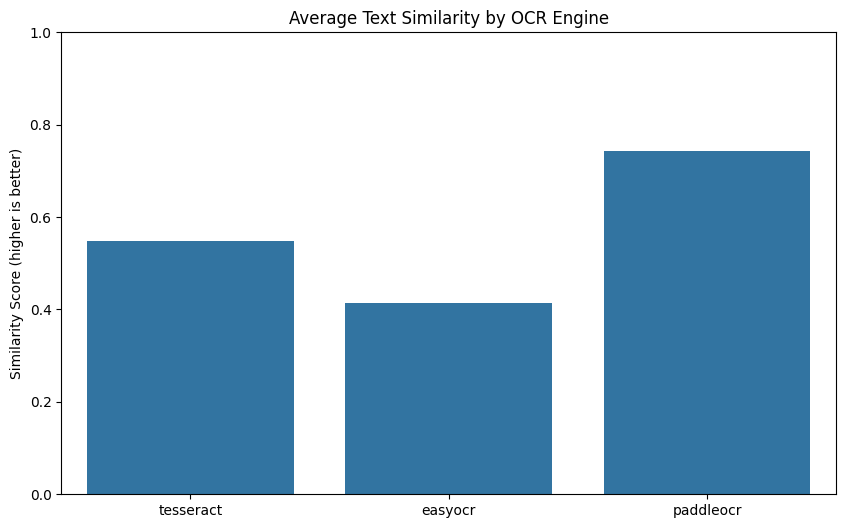

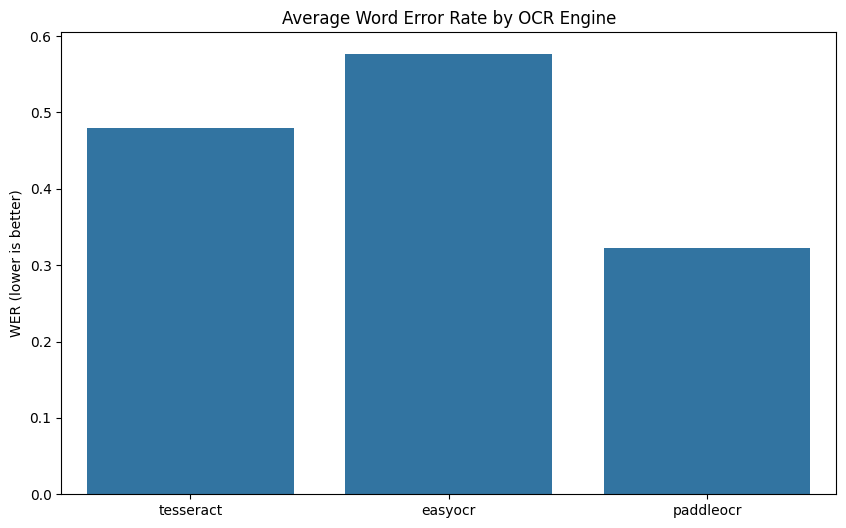

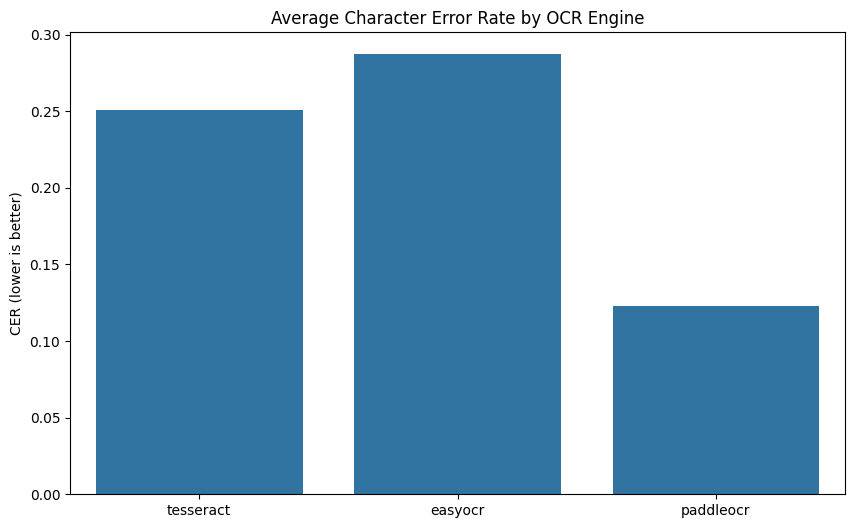

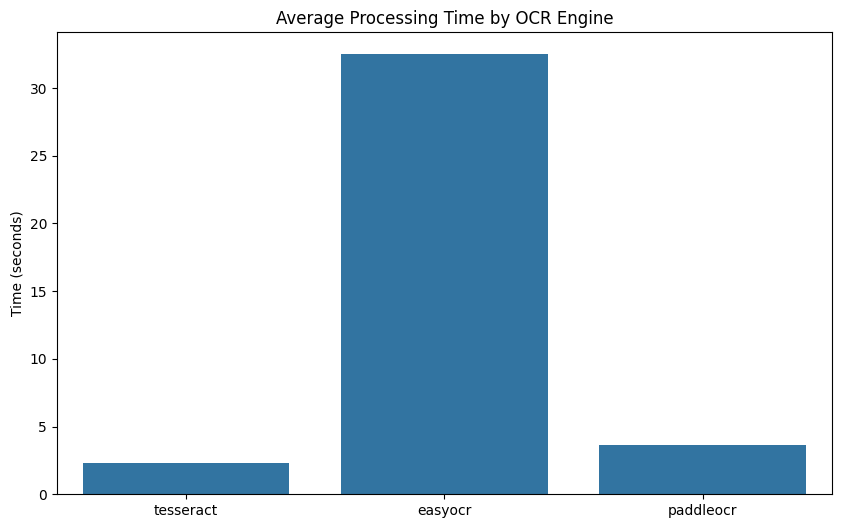

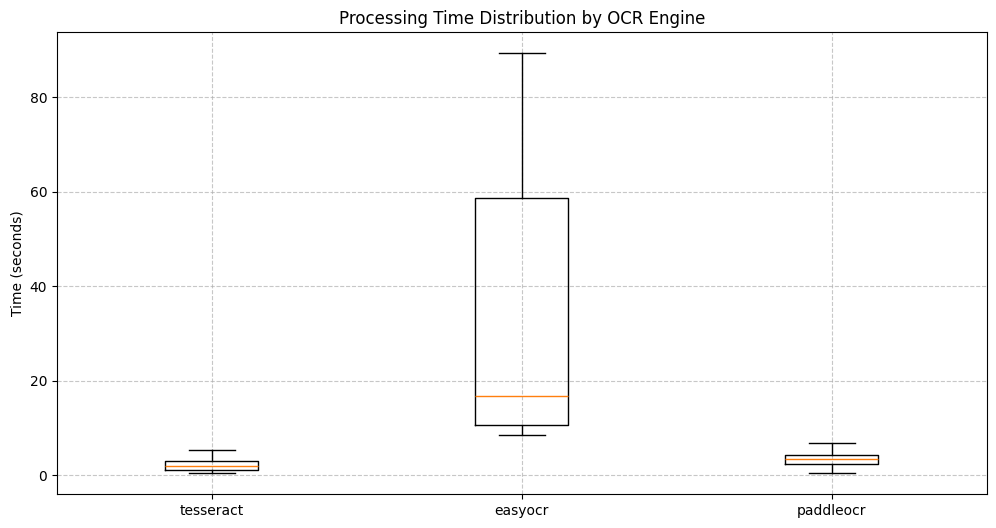

In [17]:
# evaluator = OCRAccuracyEvaluator("synthetic_email_screenshots")
# evaluator = OCRAccuracyEvaluator("screen-captured")
# evaluator = OCRAccuracyEvaluator("camera-captured")
evaluator = OCRAccuracyEvaluator("email-images")

# Run the evaluation
evaluator.evaluate_all()

# Generate and save the plots
evaluator.save_results()  # This will save results to CSV
evaluator.visualize_results()  # This will create the three plots

Summary statistics:
      engine  avg_similarity  median_similarity   avg_wer  median_wer  \
0  tesseract        0.548175           0.507305  0.479182    0.430711   
1    easyocr        0.414476           0.407670  0.576177    0.540433   
2  paddleocr        0.743179           0.854628  0.323082    0.234469   

    avg_cer  median_cer  avg_processing_time  median_processing_time  \
0  0.250786    0.165736             2.312319                1.903154   
1  0.287211    0.216120            32.488377               16.762938   
2  0.122861    0.072454             3.646111                3.489282   

   min_processing_time  max_processing_time  
0             0.587363             5.456009  
1             8.562123            89.329139  
2             0.424104             6.849616  

Loaded 24 results for tesseract

Loaded 24 results for easyocr

Loaded 24 results for paddleocr


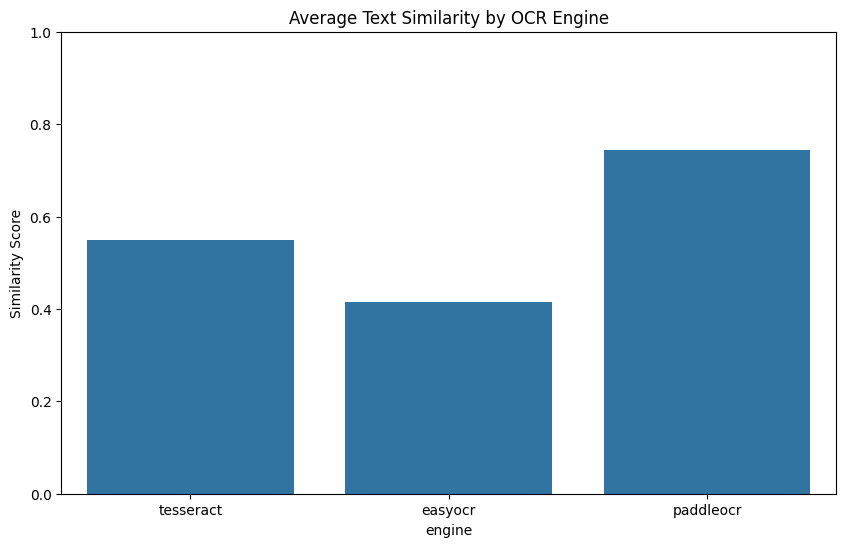

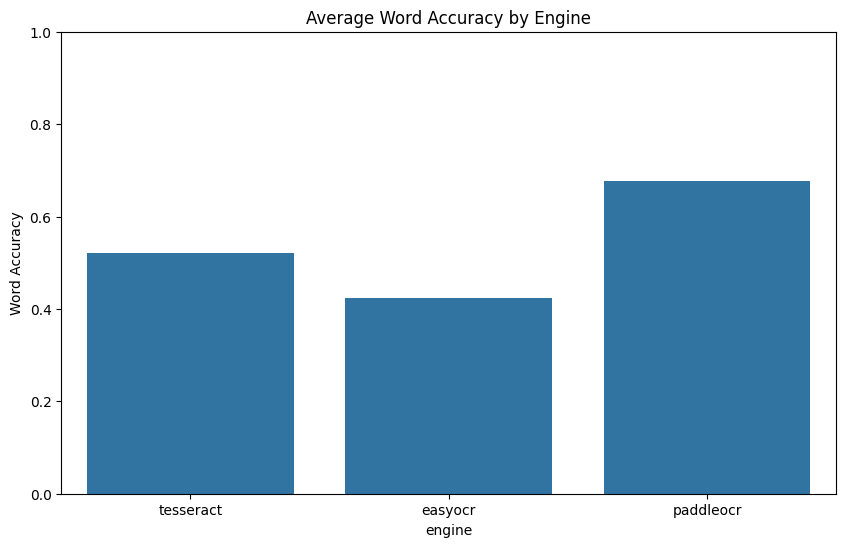

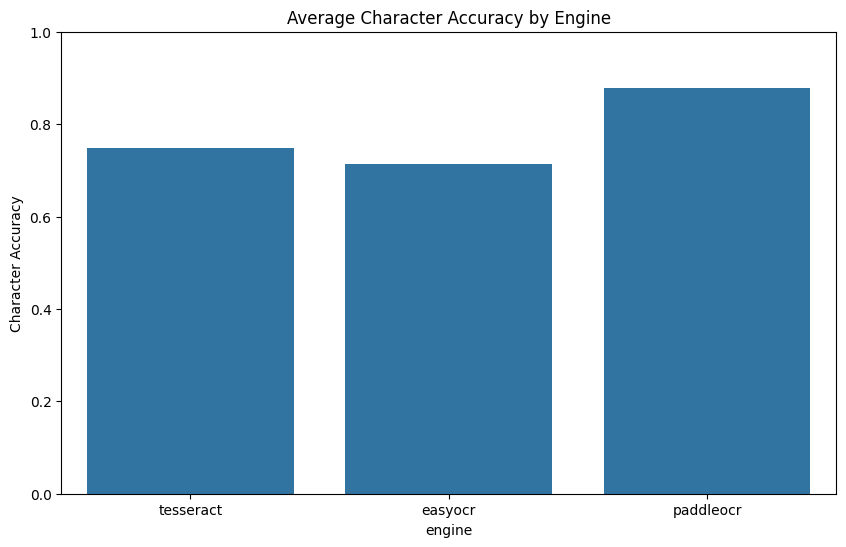

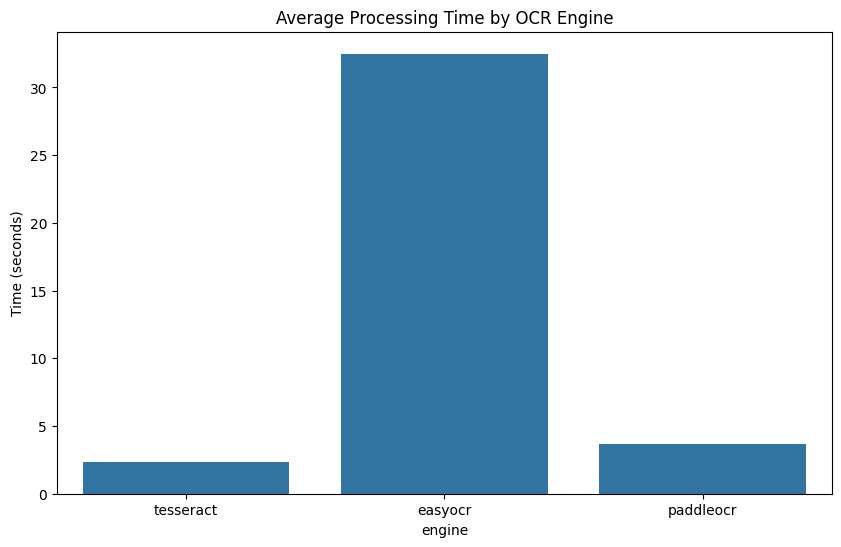

In [32]:
def load_and_visualize_results(output_dir="ocr_results"):
    """Load OCR results from CSV files and recreate visualizations."""
    # Load the summary CSV
    summary_path = os.path.join(output_dir, "summary.csv")
    if not os.path.exists(summary_path):
        print(f"Summary file not found at {summary_path}")
        return

    summary_df = pd.read_csv(summary_path)
    print("Summary statistics:")
    print(summary_df)

    # Load individual engine results
    engines = ["tesseract", "easyocr", "paddleocr"]
    engine_results = {}

    for engine in engines:
        engine_path = os.path.join(output_dir, f"{engine}_results.csv")
        if os.path.exists(engine_path):
            engine_results[engine] = pd.read_csv(engine_path)
            print(f"\nLoaded {len(engine_results[engine])} results for {engine}")
        else:
            print(f"Results for {engine} not found at {engine_path}")

    # Create visualizations
    os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)

    # Only proceed with engines that have data
    available_engines = list(engine_results.keys())
    if not available_engines:
        print("No engine results available for visualization")
        return

    # Plot average similarity scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x=summary_df["engine"], y=summary_df["avg_similarity"])
    plt.title("Average Text Similarity by OCR Engine")
    plt.ylabel("Similarity Score")
    plt.ylim(0, 1)
    plt.savefig(os.path.join(output_dir, "visualizations", "avg_similarity.png"))
    plt.show()

    # Plot inverted WER (1-WER)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=summary_df["engine"], y=1-summary_df["avg_wer"])
    plt.title("Average Word Accuracy by Engine")
    plt.ylabel("Word Accuracy")
    plt.ylim(0, 1)
    plt.savefig(os.path.join(output_dir, "visualizations", "word_accuracy.png"))
    plt.show()

    # Plot inverted CER (1-CER)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=summary_df["engine"], y=1-summary_df["avg_cer"])
    plt.title("Average Character Accuracy by Engine")
    plt.ylabel("Character Accuracy")
    plt.ylim(0, 1)
    plt.savefig(os.path.join(output_dir, "visualizations", "char_accuracy.png"))
    plt.show()

    # Plot average processing time
    plt.figure(figsize=(10, 6))
    sns.barplot(x=summary_df["engine"], y=summary_df["avg_processing_time"])
    plt.title("Average Processing Time by OCR Engine")
    plt.ylabel("Time (seconds)")
    plt.savefig(os.path.join(output_dir, "visualizations", "avg_processing_time.png"))
    plt.show()

    return summary_df, engine_results

# Usage
summary_df, engine_results = load_and_visualize_results("ocr_results")

In [33]:
!zip -r ocr_results.zip ocr_results

updating: ocr_results/ (stored 0%)
updating: ocr_results/avg_similarity.png (deflated 24%)
updating: ocr_results/paddleocr_results.csv (deflated 67%)
updating: ocr_results/summary.csv (deflated 47%)
updating: ocr_results/tesseract_results.csv (deflated 65%)
updating: ocr_results/processing_time_boxplot.png (deflated 26%)
updating: ocr_results/visualizations/ (stored 0%)
updating: ocr_results/visualizations/avg_similarity.png (deflated 25%)
updating: ocr_results/visualizations/word_accuracy.png (deflated 26%)
updating: ocr_results/visualizations/processing_time_boxplot.png (deflated 26%)
updating: ocr_results/visualizations/normalized_metrics.png (deflated 21%)
updating: ocr_results/visualizations/char_accuracy.png (deflated 25%)
updating: ocr_results/visualizations/avg_wer.png (deflated 25%)
updating: ocr_results/visualizations/avg_processing_time.png (deflated 25%)
updating: ocr_results/visualizations/avg_cer.png (deflated 25%)
updating: ocr_results/avg_wer.png (deflated 26%)
updating